# Start

In [ ]:
path="/content/drive/MyDrive/Wanchem colab/Final colab /"

In [ ]:
!pip install deepchem

     |████████████████████████████████| 552 kB 5.1 MB/s 


In [ ]:
pip install git+https://github.com/hcji/seq_encode.git

  Cloning https://github.com/hcji/seq_encode.git to /tmp/pip-req-build-607ey3cu
  Running command git clone -q https://github.com/hcji/seq_encode.git /tmp/pip-req-build-607ey3cu
  Created wheel for seq-encode: filename=seq_encode-0.0.2-py3-none-any.whl size=5534 sha256=fbf44ec750b118da3d31c3cf85d9c188b088f383e9d1572761023df8cbb0ff32
  Stored in directory: /tmp/pip-ephem-wheel-cache-d1tkkzer/wheels/27/d6/e7/47b91b767e173d93bed5996241f6e25bd0c6b484be2f227040
Successfully built seq-encode


In [ ]:
!pip install rdkit-pypi

     |████████████████████████████████| 19.7 MB 158 kB/s 


In [ ]:
import rdkit

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler
from sklearn.linear_model import BayesianRidge
from tensorflow import keras
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import deepchem as dc
from rdkit import Chem
import os
import json
from tqdm import tqdm
from seq_encode.smiles import smiles_coder

In [ ]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, concatenate
from keras.layers import Conv2D, MaxPooling2D,Conv1D,MaxPooling1D
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_csv(path+"train_with_smiles_and_pywindow.csv")

In [ ]:
test=pd.read_csv(path+"test_with_smiles_and_pywindow.csv")

In [ ]:
coder = smiles_coder()
coder.fit(data["smiles"].values)
hot_train = coder.transform(data["smiles"].values)

100%|██████████| 50181/50181 [00:04<00:00, 11233.75it/s]


In [ ]:
hot_test = coder.transform(test["smiles"].values)

100%|██████████| 17000/17000 [00:01<00:00, 12769.41it/s]


In [ ]:
hot_train.shape

(50181, 150, 41)

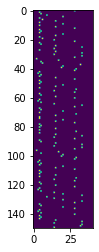

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(hot_train[0])

In [ ]:
def get_id(x):
  return int(x.split("_")[-1])

In [ ]:
id=np.vectorize(get_id)(test["MOFname"])

In [ ]:
data=data.drop(columns=["MOFname","smiles"])

In [ ]:
test=test.drop(columns=["MOFname","smiles"])

In [ ]:
data["functional_groups"]=data["functional_groups"].fillna("NAN")

In [ ]:
test["functional_groups"]=test["functional_groups"].fillna("NAN")

In [ ]:
data=data.drop(columns="Unnamed: 0")

In [ ]:
test=test.drop(columns="Unnamed: 0")

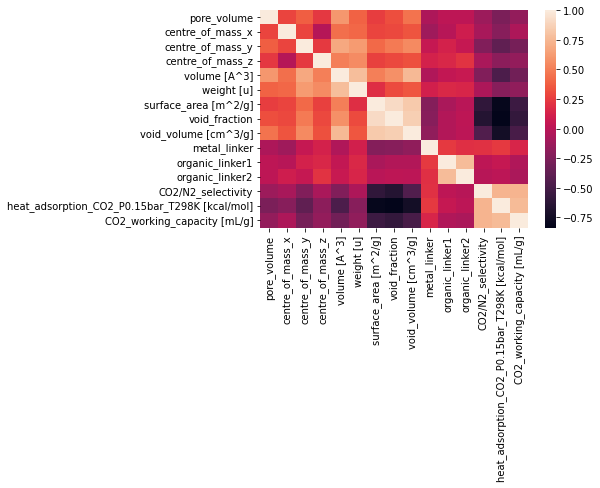

In [ ]:
import seaborn as sns
sns.heatmap(data.corr())

In [ ]:
le = LabelEncoder()
le.fit(data["functional_groups"])
data["functional_groups"]=le.transform(data["functional_groups"])
test["functional_groups"]=le.transform(test["functional_groups"])
le.fit(data["topology"])
data["topology"]=le.transform(data["topology"])
test["topology"]=le.transform(test["topology"])

In [ ]:
std=MinMaxScaler()
std.fit(data.iloc[:,:-1])
data.iloc[:,:-1]=std.transform(data.iloc[:,:-1])
test.iloc[:,:]=std.transform(test.iloc[:,:])

In [ ]:
y=data.iloc[:,-1:]
train=data.iloc[:,:-1]

# multi input deep learning

In [ ]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(hot_train.reshape(-1,150,41,1), y, test_size=0.10,random_state =0)

In [ ]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(train, y, test_size=0.10,random_state =0)

In [ ]:
X_train_cnn.shape,X_train_nn.shape

((45162, 150, 41, 1), (45162, 16))

In [ ]:
# define two sets of inputs
inputA = Input(shape=(16,))
inputB = Input(shape=(150,41,1))


# the first branch operates on the first input

x = Dense(392, activation="relu")(inputA)
x = BatchNormalization()(x)
x = Dropout(0.20)(x)
x = Dense(196, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.20)(x)
x = Dense(96, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.20)(x)
x = Dense(48, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)

# the second branch opreates on the second input
y = Conv2D(32, kernel_size=(3, 3), activation ='relu',padding='same')(inputB)
y = MaxPooling2D((2, 2),padding='same')(y)
y = Dropout(0.25)(y)
y = Conv2D(64, kernel_size=(3, 3), activation ='relu',padding='same')(y)
y = MaxPooling2D((2, 2),padding='same')(y)
y = Dropout(0.25)(y)
y = Conv2D(128, kernel_size=(3, 3), activation ='relu',padding='same')(y)
y = MaxPooling2D((2, 2),padding='same')(y)
y = Dropout(0.25)(y)
y = Conv2D(256, kernel_size=(3, 3), activation ='relu',padding='same')(y)
y = MaxPooling2D((2, 2),padding='same')(y)
y = Dropout(0.25)(y)
y = Flatten()(y)
y = Dense(256,  activation ='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.25)(y)
y = Dense(128,  activation ='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.25)(y)
y = Dense(64,  activation ='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.25)(y)
y = Dense(32,  activation ='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.25)(y)
y = Dense(16,  activation ='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.25)(y)
y = Dense(8,  activation ='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.25)(y)
y = Dense(4,  activation ='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.25)(y)
y = Dense(2,  activation ='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.25)(y)
y = Model(inputs=inputB, outputs=y)


combined = concatenate([x.output, y.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(50,activation="tanh")(combined)
z = BatchNormalization()(z)
z = Dropout(0.20)(z)
z = Dense(25)(z)
z = LeakyReLU()(z)
z = BatchNormalization()(z)
z = Dropout(0.20)(z)
z = Dense(12)(z)
z = LeakyReLU()(z)
z = BatchNormalization()(z)
z = Dropout(0.20)(z)
z = Dense(6)(z)
z = LeakyReLU()(z)
z = BatchNormalization()(z)
z = Dropout(0.20)(z)
z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', optimizer=opt, metrics=['mean_absolute_error'])
checkpoint = ModelCheckpoint(path+'model_9_2_combine_best.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  
model.fit(x=[X_train_nn, X_train_cnn],y=y_train_nn, epochs=2000, batch_size=512,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/2000
71/71 [==============================] - 10s 88ms/step - loss: 110.4532 - mean_absolute_error: 110.4532 - val_loss: 112.6593 - val_mean_absolute_error: 112.6593

Epoch 00001: val_loss improved from inf to 112.65933, saving model to /content/drive/MyDrive/Wanchem colab/Pup_colab/My_code/model_9_2_combine_best.h5
Epoch 2/2000
71/71 [==============================] - 6s 78ms/step - loss: 109.9497 - mean_absolute_error: 109.9497 - val_loss: 111.9253 - val_mean_absolute_error: 111.9253

Epoch 00002: val_loss improved from 112.65933 to 111.92529, saving model to /content/drive/MyDrive/Wanchem colab/Pup_colab/My_code/model_9_2_combine_best.h5
Epoch 3/2000
71/71 [==============================] - 6s 79ms/step - loss: 109.4675 - mean_absolute_error: 109.4675 - val_loss: 110.9133 - val_mean_absolute_error: 110.9133

Epoch 00003: val_loss improved from 111.92529 to 110.91329, saving model to /content/drive/MyDrive/Wanchem colab/Pup_colab/My_code/model_9_2_combine_best.h5
Epoch 4/2000

KeyboardInterrupt: ignored

In [ ]:
model=load_model(path+'/model_9_2_combine_best.h5')

In [ ]:
test_pred = model.predict(x=[test,hot_test.reshape(-1, 150,41, 1)])

In [ ]:
submission = pd.DataFrame({
    "id": id,
    "CO2_working_capacity [mL/g]": test_pred.T[0]
    })

In [ ]:
submission.to_csv("submission.csv", index=False)

In [ ]:
!ls

drive		submission_model_9_1_best.zip
sample_data	submission_model_9_best.zip
submission.csv	submission_use_cnn_onehot_model_9_best.zip


In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install zip

In [ ]:
!zip submission_model_9_2_best.zip submission.csv

  adding: submission.csv (deflated 56%)


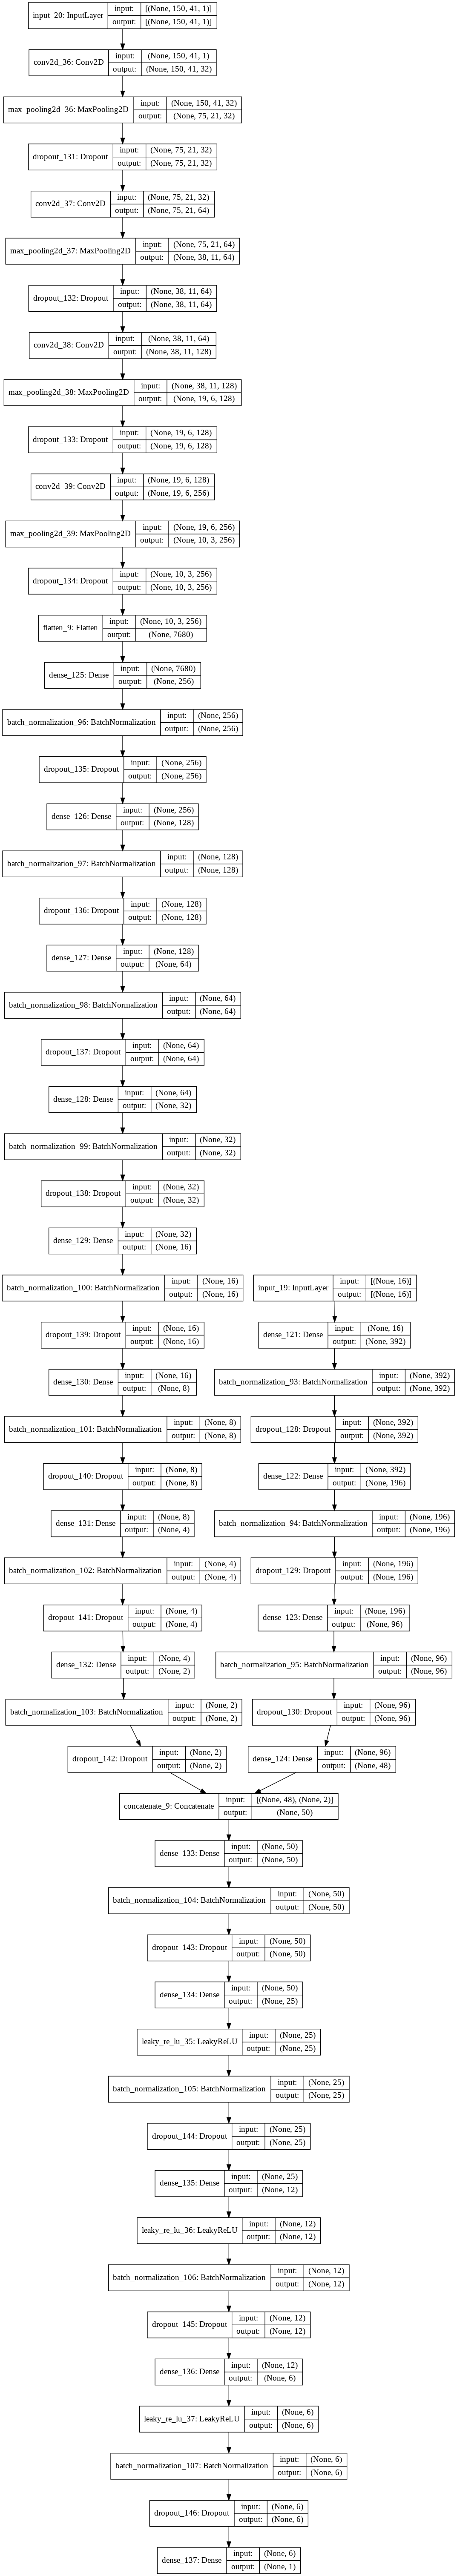

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(
model, to_file='model.png',show_shapes=True, show_dtype=False, rankdir='TB', expand_nested=False, dpi=96
)